# **Göz Hastalıkları Sınıflandırması**

*Bu Jupyter notebook, glokom, normal, diyabetik retinopati ve katarakt olmak üzere dört farklı göz hastalığı sınıflandırması için bir derin öğrenme modeli oluşturmayı amaçlamaktadır. Notebook'un bu bölümünde, modelin eğitimi için verilerin yüklenmesi ve hazırlanması adımları detaylandırılmıştır.*

# 1. **Kütüphane Yükleme ve Ayarlar**

*Bu adımda, veri işleme, görüntü manipülasyonu, veri görselleştirme ve derin öğrenme modelleri oluşturmak için gerekli olan temel kütüphaneler import edilmiştir.*

In [1]:
import os
import cv2
import pandas as pd 
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [4]:
import tensorflow as tf 
import keras 
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

2025-09-26 15:57:23.171785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758902243.423624      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758902243.487557      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. **Veri Seti Hazırlığı ve Ön İşleme**

* Dataset içerisinde bulunan sınıfların isimleri

In [5]:
class_names = os.listdir('/kaggle/input/eye-diseases-classification/dataset')
class_names_dict = {name:idx for idx,name in enumerate(class_names)}
print(class_names_dict)

{'glaucoma': 0, 'normal': 1, 'diabetic_retinopathy': 2, 'cataract': 3}


* Tüm görüntülerin aynı boyutta işlenebilmesi için ortak bir boyut belirledim.

In [6]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
CHANNELS = 3

In [7]:
def Load_Data():
    dataset = '/kaggle/input/eye-diseases-classification/dataset'

    images = []
    labels = []

    for folder in os.listdir(dataset):
        print(f"Load Images from {folder} File")
        for file in tqdm(os.listdir(os.path.join(dataset,folder))):
            image_path = os.path.join(os.path.join(dataset,folder),file)
            image = cv2.imread(image_path)
            image = cv2.resize(image , IMAGE_SIZE)
            image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

            images.append(image)
            labels.append(class_names_dict[folder])

    
    images = np.array(images , dtype='float32')
    labels = np.array(labels , dtype='int32')

    return (images , labels)

images , labels = Load_Data()

Load Images from glaucoma File


100%|██████████| 1007/1007 [00:21<00:00, 46.08it/s]


Load Images from normal File


100%|██████████| 1074/1074 [00:14<00:00, 74.36it/s]


Load Images from diabetic_retinopathy File


100%|██████████| 1098/1098 [00:14<00:00, 76.09it/s]


Load Images from cataract File


100%|██████████| 1038/1038 [00:21<00:00, 47.20it/s]


# 3. **Veri Bölme ve Doğrulama**

* Shuffle işlevi, bir liste veya dizideki öğeleri rastgele yeniden düzenlemek için kullanılır. Temel amacı, verileri karıştırarak örneklerin orijinal, sıralı düzenlerinden çıkmasını sağlamaktır.

In [8]:
images , labels = shuffle(images , labels , random_state=42)    

In [9]:
print(f"Toplam Görsel Sayısı: {images.shape[0]}")
print(f"Görsel Boyutu: {IMAGE_SIZE}")

Toplam Görsel Sayısı: 4217
Görsel Boyutu: (224, 224)


* Veri setini model için üç ayrı parçaya ayırdım. Train, validation ve test. 

In [10]:
train_images , dummy_images , train_labels , dummy_labels = train_test_split(images , labels , test_size=0.3, random_state=42, stratify=labels)

val_images , test_images , val_labels , test_labels = train_test_split(dummy_images , dummy_labels , test_size=0.5, random_state=42, stratify=dummy_labels)

In [11]:
print(f"Train Görüntü Sayısı: {train_images.shape}")
print(f"Train Label Sayısı: {train_labels.shape}")
print(f"Validation Görüntü Sayısı: {val_images.shape}")
print(f"Validation Label Sayısı: {val_labels.shape}")
print(f"Test Görüntü Sayısı: {test_images.shape}")  
print(f"Test Label Sayısı: {test_labels.shape}") 

Train Görüntü Sayısı: (2951, 224, 224, 3)
Train Label Sayısı: (2951,)
Validation Görüntü Sayısı: (633, 224, 224, 3)
Validation Label Sayısı: (633,)
Test Görüntü Sayısı: (633, 224, 224, 3)
Test Label Sayısı: (633,)


In [12]:
train_counts = np.unique(train_labels, return_counts=True)[1]
val_counts = np.unique(val_labels, return_counts=True)[1]
test_counts = np.unique(test_labels, return_counts=True)[1]

df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}, index=class_names)

In [13]:
df

Train  Validation  Test
glaucoma                705         151   151
normal                  752         161   161
diabetic_retinopathy    768         165   165
cataract                726         156   156

<Figure size 1200x600 with 0 Axes>

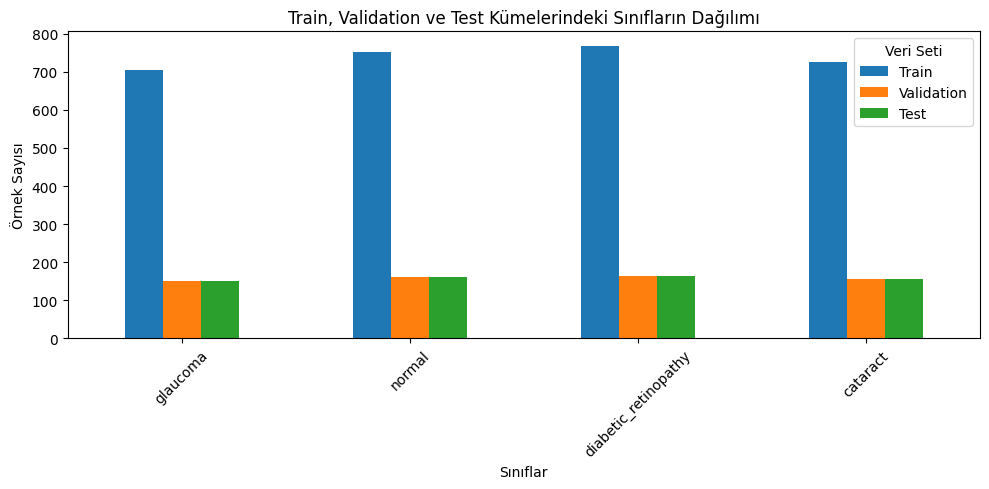

In [14]:
plt.figure(figsize=(12, 6))
df.plot(kind='bar',figsize=(10,5))
plt.title('Train, Validation ve Test Kümelerindeki Sınıfların Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=45)
plt.legend(title='Veri Seti')
plt.tight_layout()
plt.show()

* Her sınıftan örnek görüntüler.

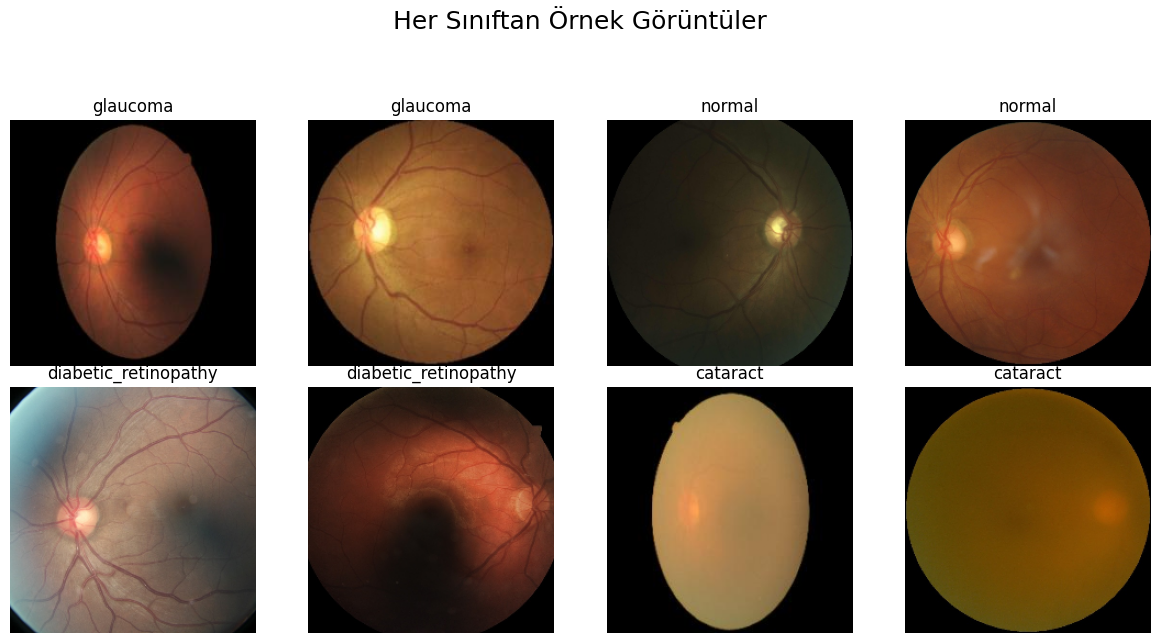

In [16]:
num_classes = len(class_names)
images_per_class = 2 
total_images_to_show = num_classes * images_per_class

rows = 2
cols = 4 

plt.figure(figsize=(12,6)) 

plt.suptitle('Her Sınıftan Örnek Görüntüler', fontsize=18, y=1.05) 

all_selected_indices = []
for class_idx in range(num_classes):
    category_list = np.where(labels == class_idx)[0]
    
    if len(category_list) == 0:
        print(f"Uyarı: '{class_names[class_idx]}' sınıfında görüntü yok.")
        continue

    current_images_to_show = min(images_per_class, len(category_list))
    if len(category_list) > current_images_to_show:
        selected_indices = np.random.choice(category_list, current_images_to_show, replace=False)
    else:
        selected_indices = category_list

    all_selected_indices.extend(selected_indices)


for i, img_idx in enumerate(all_selected_indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[img_idx] / 255.0)
    plt.axis('off')
    
    class_name = class_names[labels[img_idx]]
    plt.title(f'{class_name}')

plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.96])
plt.show()

# 4. **Veri Normalizasyonu**

*Bu kısımda, ham görüntü verileri derin öğrenme modelinin daha iyi öğrenmesi için hazırlanır. Normalizasyon, piksel değerlerini 0-1 aralığına getirerek eğitim sürecini hızlandırır ve modelin performansını artırır.*

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40, horizontal_flip = True,)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

*Bu bölümde, modelin aşırı öğrenmesini (overfitting) engellemek ve daha genelleştirilebilir bir yapıya sahip olmasını sağlamak için veri artırma teknikleri kullanılmıştır.*

In [18]:
train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=BATCH_SIZE, shuffle=True)

val_generator = val_datagen.flow(x=val_images, y=val_labels, batch_size=BATCH_SIZE, shuffle=True)

test_generator = test_datagen.flow(x=test_images, y=test_labels, batch_size=BATCH_SIZE, shuffle=False)

* Üretilen yeni görüntülerden örnekler

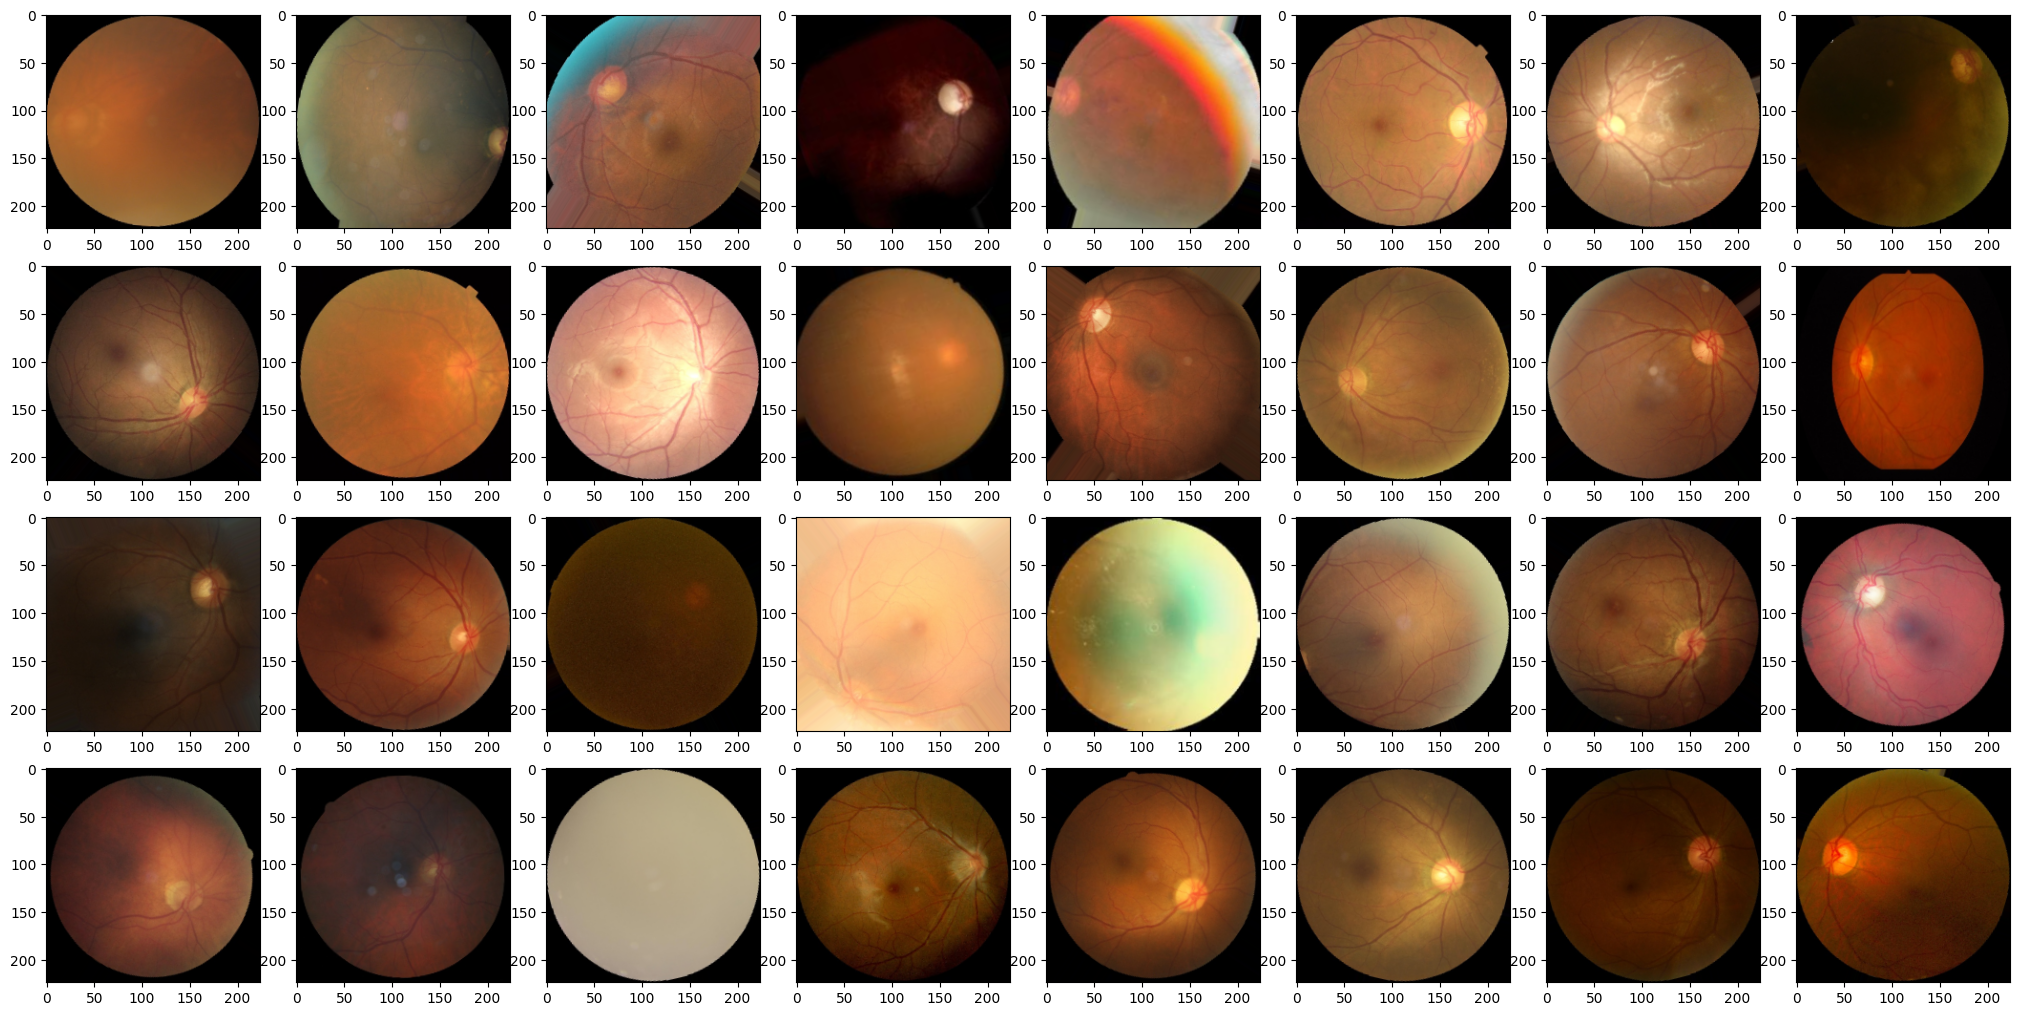

In [19]:
for x , y in train_generator:
    plt.figure(figsize=(20,20))
    for i in range(32):
        plt.subplot(8,8,i+1)
        plt.imshow(x[i])
        plt.tight_layout(pad=0 , h_pad=0 , w_pad=0)
    break

# 5. **Model Mimarisi: Convolutional Neural Network (CNN)**

Modelin katmanları şunları içermektedir:

* Evrişim Katmanları (Conv2D): Görüntüdeki özellik haritalarını (feature maps) çıkarmak için kullanılır. İlk katmanlarda 32, ardından 64 ve 128 filtre ile daha karmaşık özellikler öğrenilir.

* Aktivasyon Fonksiyonu (relu): Evrişim katmanlarından sonra kullanılır ve doğrusal olmayan bir ilişki kurarak modelin karmaşık kalıpları öğrenmesine yardımcı olur.

* Max Pooling Katmanları (MaxPooling2D): Görüntü boyutunu küçülterek hesaplama yükünü azaltır ve önemli özelliklerin korunmasını sağlar.

* Düzleştirme (Flatten): Evrişim katmanlarından gelen 2 boyutlu çıktıları, tam bağlantılı katmanlara girdi olarak verilebilmesi için 1 boyutlu bir vektöre dönüştürür.

* Tam Bağlantılı Katmanlar (Dense): Bu katmanlar, sınıflandırma işlemini gerçekleştirir. Modelin sonunda, 4 farklı sınıfa ait olasılıkları hesaplayan 4 nöronlu bir çıktı katmanı (softmax) bulunur.

In [30]:
KerasModel = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4, activation='softmax')
])

# 6. **Model Derleme ve Eğitim**

In [31]:
KerasModel.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy']
                  )

In [32]:
best_model_callback = keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

early_stopping_callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)  

learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                                            patience=2,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001,
                                                           )

In [33]:
history = KerasModel.fit(
    train_generator,
    epochs=150,
    validation_data=val_generator,
    callbacks=[
        early_stopping_callback,
        best_model_callback,
        learning_rate_reduction
    ])

Epoch 1/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 352ms/step - accuracy: 0.4295 - loss: 1.2073 - val_accuracy: 0.5671 - val_loss: 0.8784 - learning_rate: 0.0010
Epoch 2/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 313ms/step - accuracy: 0.5695 - loss: 0.8731 - val_accuracy: 0.6477 - val_loss: 0.7589 - learning_rate: 0.0010
Epoch 3/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 321ms/step - accuracy: 0.6527 - loss: 0.7620 - val_accuracy: 0.6840 - val_loss: 0.6784 - learning_rate: 0.0010
Epoch 4/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 309ms/step - accuracy: 0.6698 - loss: 0.7207 - val_accuracy: 0.7030 - val_loss: 0.6359 - learning_rate: 0.0010
Epoch 5/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 297ms/step - accuracy: 0.7155 - loss: 0.6412 - val_accuracy: 0.7109 - val_loss: 0.6426 - learning_rate: 0.0010
Epoch 6/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 308ms/step - accuracy: 0.7129 - loss: 0.6247 - val_accuracy: 0.7156 - val_loss: 0.6079 - learning_rate: 0.0010
Epoch 7/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - accuracy: 0.7447 - l

In [34]:
print(KerasModel.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,377,966 (298.99 MB)

 Trainable params: 26,125,988 (99.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,251,978 (199.33 MB)

None


# 7. **Model Performansı ve Sonuçları**

*Bu grafikler, modelin eğitim (training) ve doğrulama (validation) süreçlerindeki performansını görselleştirmektedir. Modelin aşırı öğrenme (overfitting) eğilimini ve genel başarısını anlamak için bu grafikler kritik önem taşır.*

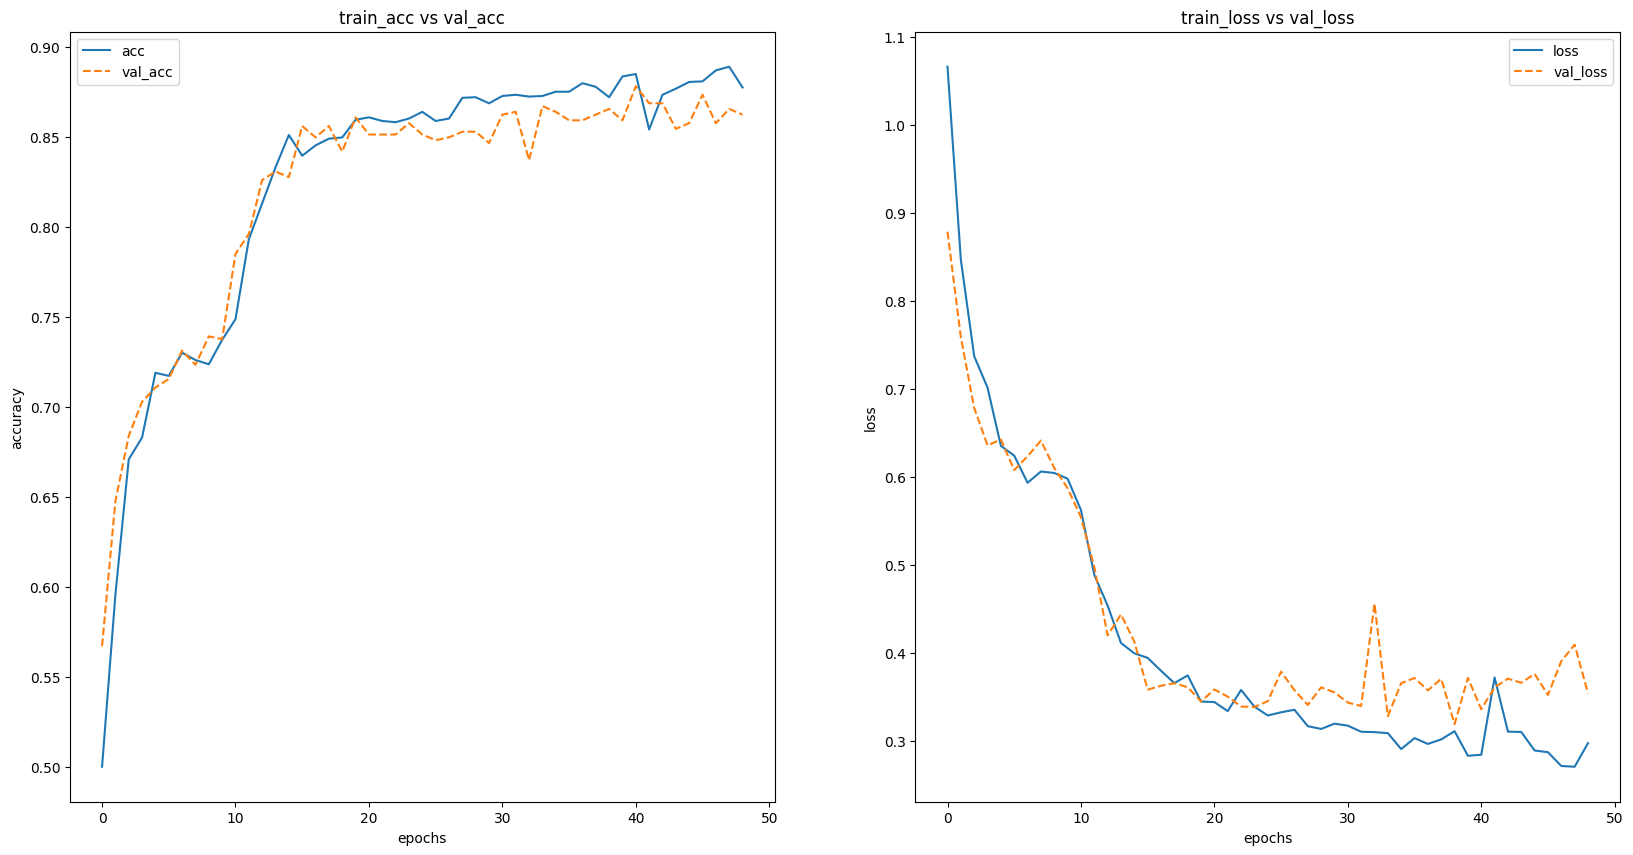

In [35]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'-', label = "acc")
    plt.plot(history.history['val_accuracy'], '--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'-', label = "loss")
    plt.plot(history.history['val_loss'], '--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(history)    

* **Doğruluk (Accuracy) Grafiği:** Mavi çizgi eğitim verisi, turuncu çizgi ise doğrulama verisi üzerindeki performansı gösterir. Eğitim süreci ilerledikçe, hem eğitim hem de doğrulama doğruluğu artmaktadır. Ancak, eğitim doğruluğu ve doğrulama doğruluğu arasındaki farkın az olması, modelin eğitim verilerini ezberlemediğini, yeni verilere genelleme yapabildiğini gösterir.

* **Kayıp (Loss) Grafiği:** Bu grafik, modelin yaptığı hataları (kayıp) gösterir ve daha düşük olması daha iyidir. Eğitim kaybı hızla düşerken, doğrulama kaybı daha yüksek bir seviyede kalmıştır. Model, eğitim verilerindeki hataları başarıyla en aza indirmiş, ancak doğrulama verilerindeki hatalar yüksek seyretmiştir.

In [36]:
model = keras.models.load_model('best_model.h5')
predictions = model.predict(test_generator)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


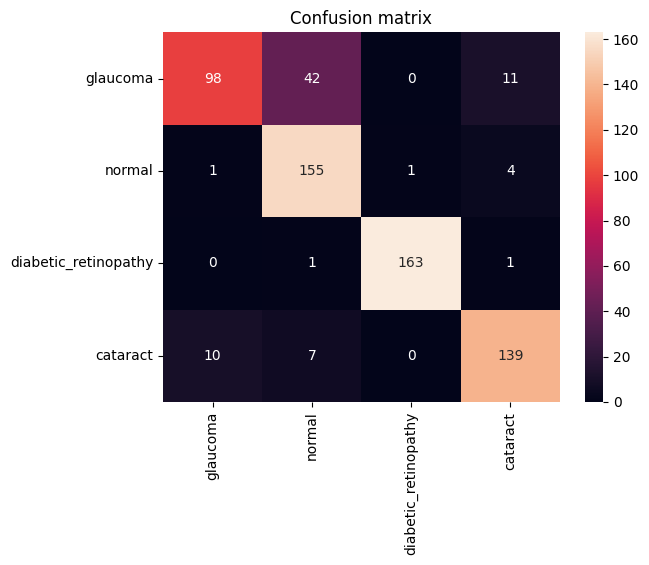

In [37]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels = class_names, 
           yticklabels = class_names,
           ax = ax,           
           fmt='d')
ax.set_title('Confusion matrix')
plt.show()

* *Bu confusion matrix incelendiğinde modelin genel olarak normal ve diabetic retinopathy sınıflarında oldukça başarılı olduğu görülmektedir. Her iki sınıfta da doğru sınıflandırma oranı çok yüksek olup yalnızca birkaç örnekte hata yapılmıştır. Buna karşın, glaucoma sınıfında ciddi bir karışıklık söz konusudur; özellikle normal sınıfı ile sıkça karıştırıldığı dikkat çekmektedir. Bu durum, modelin glaucoma’ya özgü ayırt edici özellikleri yeterince öğrenemediğini göstermektedir. Cataract sınıfı ise büyük oranda doğru tahmin edilmekle birlikte, zaman zaman glaucoma ve normal sınıfına kaymalar yaşanmaktadır. Genel değerlendirmede modelin bazı sınıflarda yüksek başarı gösterdiği, ancak özellikle glaucoma sınıfında performansın iyileştirilmesine ihtiyaç duyulduğu sonucuna varılabilir.*

In [38]:
print(classification_report(test_labels, pred_labels,target_names = class_names))

                      precision    recall  f1-score   support

            glaucoma       0.90      0.65      0.75       151
              normal       0.76      0.96      0.85       161
diabetic_retinopathy       0.99      0.99      0.99       165
            cataract       0.90      0.89      0.89       156

            accuracy                           0.88       633
           macro avg       0.89      0.87      0.87       633
        weighted avg       0.89      0.88      0.87       633



* **Precision (Kesinlik):** Modelin bir sınıf için doğru olarak tahmin ettiği pozitif örneklerin, o sınıf için tahmin ettiği tüm pozitif örneklere oranıdır. Yüksek precision, modelin bir sınıfı doğru tahmin etme konusunda güvenilir olduğunu gösterir. Örneğin, diyabetik retinopati için %0.99'luk precision, modelin bu hastalığı teşhis ettiğinde neredeyse her zaman doğru olduğunu belirtir. Glokom için ise bu oran %0.90'dır.

* **Recall (Duyarlılık):** Gerçekte pozitif olan örneklerin ne kadarının model tarafından doğru bir şekilde tahmin edildiğini gösterir. Yüksek recall, modelin bir hastalığı kaçırma olasılığının düşük olduğunu gösterir. Örneğin, diyabetik retinopati için %0.99'luk recall, gerçek diyabetik retinopati vakalarının neredeyse tamamını yakaladığını gösterir. Glokom için ise %0.65'lik recall, bu hastalığın vakalarının %35'ini kaçırdığını, yani yanlış sınıflandırdığını belirtir.

* **F1-Score:** Precision ve recall'ın harmonik ortalamasıdır. Hem precision hem de recall'ın dengeli bir şekilde yüksek olduğu durumlarda f1-score da yüksek olur. Bu, tek bir metrik yerine modelin genel performansını değerlendirmek için kullanışlıdır.

* **Support:** Her bir sınıftaki gerçek örnek sayısını gösterir. Bu, modelin performansının değerlendirildiği örneklem büyüklüğünü anlamanıza yardımcı olur.

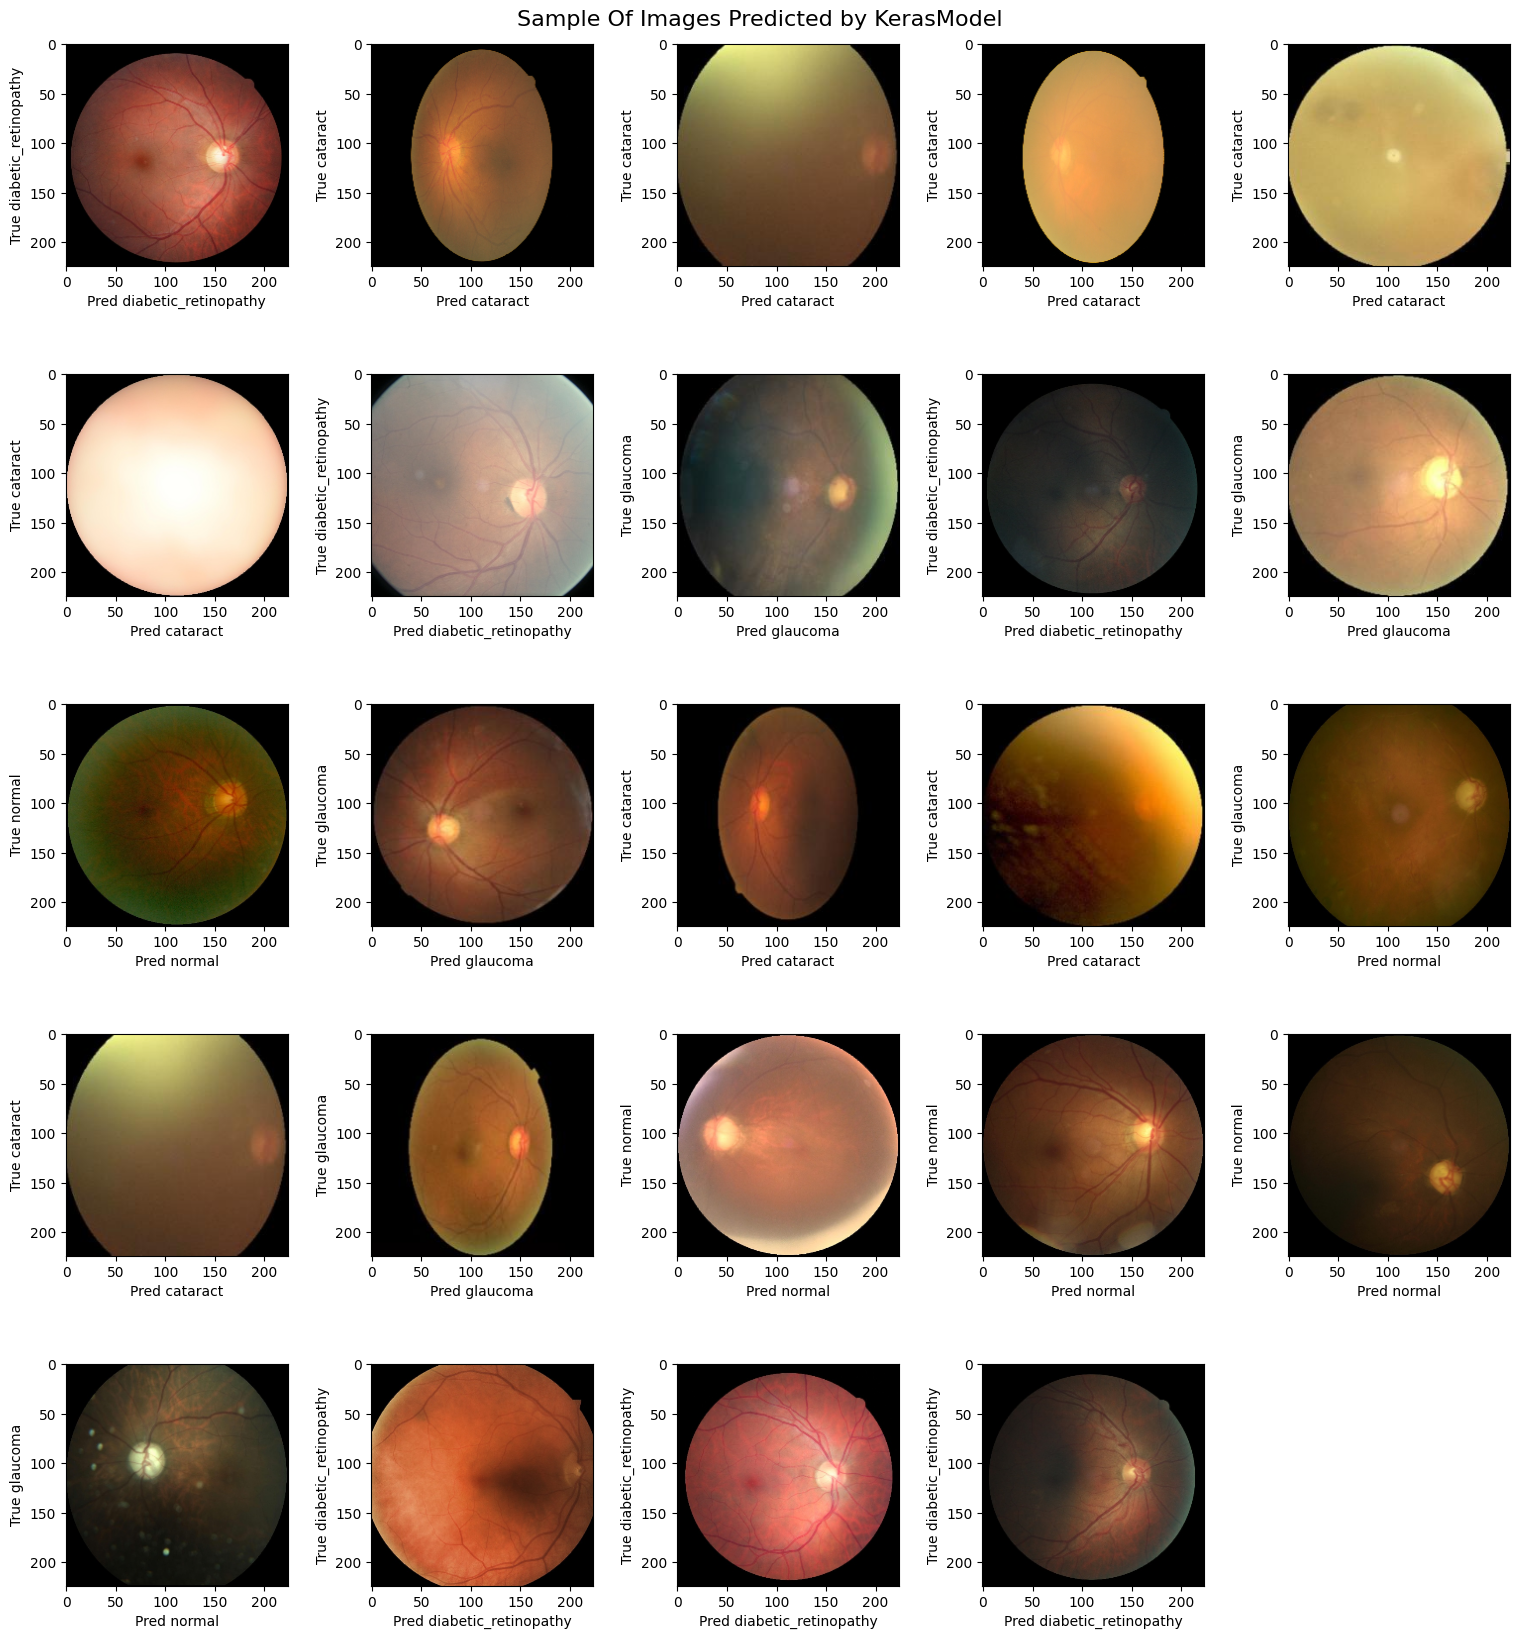

In [43]:
plt.figure(figsize=(15,20))
plt.suptitle(f"Sample Of Images Predicted by KerasModel" , fontsize=16)

for i in range(24):
    plt.subplot(6,5,i+1)
    idx = np.random.choice(np.arange(len(pred_labels)))
    plt.imshow(test_images[idx] / 255.0)
    plt.xlabel(f'Pred {class_names[pred_labels[idx]]}')
    plt.ylabel(f'True {class_names[test_labels[idx]]}')
    plt.tight_layout(pad=0 , h_pad=0 , w_pad=2)